# TP Coding Convolutional Neural Networks in tensorflow and keras

TP author : Geoffroy Peeters, Alasdair Newson

**Student: VU Thi Hai Yen (haiyen96.hp@gmail.com)**

### Objective:

We want to implement a Convolutional Neural Network (CNN) to do image recognition. For this we will use the well-known CIFAR-10 dataset https://www.cs.toronto.edu/~kriz/cifar.html.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

We will first code the simple ConvNet described below using 
- tensorflow https://www.tensorflow.org

then do the same using
- keras : https://keras.io


The input of the CNN is a set of (32,32,3) image tensors. We apply :

    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we do not apply zero-padding)
    - a ReLu activation function
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we do not apply zero-padding)
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - a Convolutional layer of 32 filters of shape (3,3), with stride (1,1) and padding='same' (i.e. we do not apply zero-padding)
    - a ReLu activation function
    - a Max Pooling Layer of shape (2,2) and stride (2,2) (i.e. we reduce by two the size in each dimension)
    
    - We then Flatten the data (reduce them to a vector in order to be able to apply a Fully-Connected layer to it)
    - A softmax activation function which outputs are the $P(y_c | X)$ (multi-class problem)

### Your task:
You need to add the missing parts in the code (parts between # --- START CODE HERE and # --- END CODE HERE)

# Load packages

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Import data

We first import CIFAR-10 dataset.

In [2]:
from keras.utils.np_utils import to_categorical

from keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print(X_train.shape)
print(X_test.shape)
print(np.unique(y_train))

Using TensorFlow backend.


(50000, 32, 32, 3)
(10000, 32, 32, 3)
[0 1 2 3 4 5 6 7 8 9]


The CIFAR-10 dataset has 10 classes. These are the following :

In [0]:
cifar_10_list = [ 'airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']

### Display some of the images

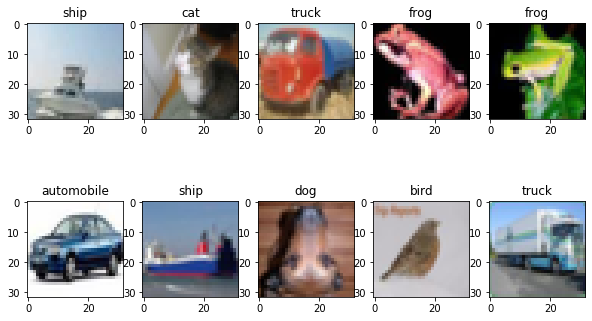

In [4]:
plt.figure(figsize=(10, 6))
for idx,i in enumerate(range(100,110)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(X_train[i, :, :, :])
    plt.title(cifar_10_list[int(y_train[i])])

In [0]:
y_train.shape

(50000, 1)

## Format conversion

We now convert the format of the data. In the case of CNNs, and contrary to MLPs, the inputs are not simply vectors of arbitrary size. For example, in the case of images, it is important to distinguish the different dimensions (otherwise the network would not know how to carry out convolutions). Therefore, you need to carry out the following operation :

- reshape the input ```X_train```and ```X_test``` to a set of matrices of size (32,32) and depth 3 (for the 3 R,G,B colors), convert the data to float32 and normalize them in the range [0,1]. The final dimensions of the image data should be : [batch_size, height, width, n_channels]

Furthermore, as in the previous lab work, you must also convert the label vectors to matrices with k columns, where k is the number of classes. This allows us to carry out the cross-entropy for multi-class problems. Therefore :

- convert the output label ```y_train``` and ```y_test``` to one-hot encoding format.

In [5]:
# input image dimensions
img_rows, img_cols, nb_channels = 32, 32, 3
nb_classes = 10

# In case depth is 1 (black and white pictures) -> reshape to proper format
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, nb_channels)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, nb_channels)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('Y_train shape:', Y_train.shape)
print('There is {} train data'.format(X_train.shape[0]))
print('There is {} test data'.format(X_test.shape[0]))
print(img_rows, img_cols, nb_channels)

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
Y_train shape: (50000, 10)
There is 50000 train data
There is 10000 test data
32 32 3


For memory and speed reasons, we are going to reduce the amount of training data :

In [6]:
n_train_samples = 10000
X_train = X_train[0:n_train_samples,:,:,:]
Y_train = Y_train[0:n_train_samples,:]
print(X_train.shape)
print(Y_train.shape)

(10000, 32, 32, 3)
(10000, 10)


# 1. CNN with tensorflow

We are now going to create a CNN with Tensorflow, and train it on the previously loaded CIFAR dataset.
- First define the input and output using ```tf.placeholder```
- Define the weights and biases of the CNN using ```tf.variable``` or ```tf.get_variable```
    - You can initialize them using ```tf.contrib.layers.xavier_initializer```(see https://www.tensorflow.org/api_docs/python/tf/contrib/layers/xavier_initializer)
- Perform the convolution using ```tf.nn.conv2d``` 
- Apply the activation function using ```tf.nn.relu```
- Perform the max pooling using ```tf.nn.max_pool```
- Flatten the output of the convolution using ```tf.contrib.layers.flatten```
- Perform the Fully-Connected part using ```tf.contrib.layers.fully_connected```

Also, note that in Tensorflow, you can carry out the softmax + cross entropy all in one step with the following function :

- ```tf.nn.softmax_cross_entropy_with_logits()```

This has the advantage of being optimised and stabilised by the programmers who wrote Tensorflow, so that you do not have numerical problems.

$\textbf{IMPORTANT NOTE}$ : Please note that this part in Tensorflow is just so that you have had some experience with CNNs in Tensorflow. So do not spend a lot of time trying to get great accuracy results. If you want to do this, do it in the Keras part.

In [0]:
import tensorflow as tf

learning_rate = 0.01
n_epochs = 20
batch_size = 64

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)


# --- Size of the successice layers
n_h_0 = nb_channels
n_h_1 = nb_filters
n_h_2 = nb_filters
n_h_3 = nb_filters

In [8]:
tf.reset_default_graph()

# input tensor are of shape [batch, in_height, in_width, in_channels]  
# filter / kernel tensor are of shape [filter_height, filter_width, in_channels, out_channels]

# --- START CODE HERE
# Define placeholder for input and output
X_input = tf.placeholder("float32", shape=(None, img_rows, img_cols, nb_channels), name="input")
Y_output = tf.placeholder("float32", shape=(None, nb_classes), name="output")

# Define variables
weights = {
    'wc1': tf.get_variable('W0', shape=(kernel_size[0],kernel_size[1],n_h_0,n_h_1), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc2': tf.get_variable('W1', shape=(kernel_size[0],kernel_size[1],n_h_1,n_h_2), initializer=tf.contrib.layers.xavier_initializer()), 
    'wc3': tf.get_variable('W2', shape=(kernel_size[0],kernel_size[1],n_h_2,n_h_3), initializer=tf.contrib.layers.xavier_initializer())
}
biases = {
    'bc1': tf.get_variable('B0', shape=(n_h_1), initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable('B1', shape=(n_h_2), initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable('B2', shape=(n_h_3), initializer=tf.contrib.layers.xavier_initializer())
}

# Define the model
## Conv1
conv1 = tf.nn.bias_add(tf.nn.conv2d(X_input, weights['wc1'], strides=[1, 1], padding='SAME'),
                             biases['bc1'])
conv1 = tf.nn.relu(conv1)

## Conv2
conv2 = tf.nn.bias_add(tf.nn.conv2d(conv1, weights['wc2'], strides=[1, 1], padding='SAME'),
                             biases['bc2'])
conv2 = tf.nn.relu(conv2)
conv2 = tf.nn.max_pool(conv2, ksize=pool_size, strides=pool_size,padding='SAME')

## Conv3
conv3 = tf.nn.bias_add(tf.nn.conv2d(conv2, weights['wc3'], strides=[1, 1], padding='SAME'),
                             biases['bc3'])
conv3 = tf.nn.relu(conv3)
conv3 = tf.nn.max_pool(conv3, ksize=pool_size, strides=pool_size,padding='SAME')

## FC
fc = tf.contrib.layers.flatten(conv3)
fc = tf.contrib.layers.fully_connected(fc,nb_classes, activation_fn=None)
Z4 = fc

# --- END CODE HERE

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z4, labels = Y_output))
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



## Train the model

Cost after epoch 0: 2.235506
Cost after epoch 1: 1.876066
Cost after epoch 2: 1.671968
Cost after epoch 3: 1.605194
Cost after epoch 4: 1.538222
Cost after epoch 5: 1.492359
Cost after epoch 6: 1.454168
Cost after epoch 7: 1.413546
Cost after epoch 8: 1.412484
Cost after epoch 9: 1.404810
Cost after epoch 10: 1.369418
Cost after epoch 11: 1.331563
Cost after epoch 12: 1.327725
Cost after epoch 13: 1.327829
Cost after epoch 14: 1.310885
Cost after epoch 15: 1.312907
Cost after epoch 16: 1.300785
Cost after epoch 17: 1.308598
Cost after epoch 18: 1.296123
Cost after epoch 19: 1.272320


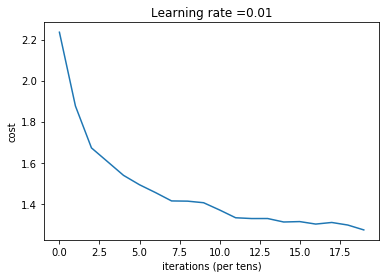

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.5691
Test Accuracy: 0.4615


In [9]:
init = tf.global_variables_initializer()
n_batches = int(np.ceil(X_train.shape[0] / float(batch_size)))
costs = []

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        minibatch_cost = 0.
        for batch_idx in range(n_batches):
            # BEGIN CODE HERE
            _ , temp_cost = sess.run([optimizer,cost], feed_dict={
                                                                  X_input: X_train[batch_idx*batch_size : min((batch_idx+1)*batch_size, len(X_train))], 
                                                                  Y_output: Y_train[batch_idx*batch_size : min((batch_idx+1)*batch_size, len(Y_train))]})
            # END CODE HERE
            minibatch_cost += temp_cost / n_batches

        if epoch % 1 == 0:
            print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            
        costs.append(minibatch_cost) 
        
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    # Calculate the correct predictions
    predict_op = tf.argmax(Z4, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y_output, 1))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print(accuracy)
    train_accuracy = accuracy.eval({X_input: X_train, Y_output: Y_train})
    test_accuracy = accuracy.eval({X_input: X_test, Y_output: Y_test})
    print("Train Accuracy:", train_accuracy)
    print("Test Accuracy:", test_accuracy)
    


The train accuracy after 20 epochs should be around 0.5. You do not have to push the training further than this, just make sure that the loss decreases and that the accuracy is reasonable. We will now create the same network in Keras.

# 2. CNN with keras

We are now going to create the same network with Keras. As we shall see, the interface is quite simplified in comparison to Tensorflow.

## We first import keras packages

In [8]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers
print(keras.__version__)

2.2.5


## We define the parameters of the model, and of the training

In [0]:
input_shape = (img_rows, img_cols, nb_channels)

## Creating the CNN model in Keras using the Sequential API

Keras has a simple way of adding layers to create a neural network. First, you can indicate to Keras that the model is 'sequential', that is to say, a straight-forward CNN. For this, you can use the following function :
- ```model = Sequential()```

After this, you can add layers with the function.

- ```model.add()```

You can then use the ```Conv2D```, ```Activation```, ```MaxPooling2D```, ```Flatten``` and ```Dense``` (fully connected) functions to specify different layer types. Note that in the case of this approach, you will have to specify the input image size in the first layer of the network. So, for example, if the first layer is convolutional :

- model = Sequential()
- model.add(Conv2D(nb_filters, kernel_size, input_shape=input_shape, name='Conv1'))


## Creating the CNN model in Keras using the standard API

Otherwise, another approach to creating the model is to explicitly create the input variable, and just cascade the different functions, as in Tensorflow. So, for the same example, we would have :

- input = Input(shape=(img_rows,img_cols,nb_channels))
- output = Conv2D(input_shape=self.img_shape,filters=nb_filters,kernel_size=kernel_size)(input)
- model = Model(input, output)

Create your CNN now with the network parameters specified above.

In [10]:
# --- START CODE HERE
model = Sequential()
model.add(Conv2D(nb_filters, kernel_size, input_shape=input_shape, padding='SAME', name='Conv1'))
model.add(Activation('relu', name='Relu1'))
model.add(Conv2D(nb_filters, kernel_size, padding='SAME', name='Conv2'))
model.add(Activation('relu', name='Relu2'))
model.add(MaxPooling2D(pool_size, name='MaxPool2'))
model.add(Conv2D(nb_filters, kernel_size, padding='SAME', name='Conv3'))
model.add(Activation('relu', name='Relu3'))
model.add(MaxPooling2D(pool_size, name='MaxPool3'))
model.add(Flatten())
model.add(Dense(nb_classes, activation='softmax', name='output'))
# --- END CODE HERE

## Compile the model

We define here the ```loss``` that we will minimize and the ```optimizer``` (the specific algorithm used to perform gradient descent).

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

## We display a summary of the model created (but not yet trained)

In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1 (Conv2D)               (None, 32, 32, 32)        896       
_________________________________________________________________
Relu1 (Activation)           (None, 32, 32, 32)        0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 32, 32, 32)        9248      
_________________________________________________________________
Relu2 (Activation)           (None, 32, 32, 32)        0         
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 16, 16, 32)        0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 16, 16, 32)        9248      
_________________________________________________________________
Relu3 (Activation)           (None, 16, 16, 32)       

## Perform the training

In [12]:
model.fit(X_train, Y_train,
          batch_size=batch_size, 
          nb_epoch=n_epochs,
          verbose=1, 
          validation_data=(X_test, Y_test))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """




Train on 10000 samples, validate on 10000 samples
Epoch 1/20





10000/10000 [==============================] - 43s 4ms/step - loss: 2.1258 - acc: 0.2172 - val_loss: 2.0326 - val_acc: 0.2600
Epoch 2/20
10000/10000 [==============================] - 43s 4ms/step - loss: 1.8827 - acc: 0.3130 - val_loss: 1.8395 - val_acc: 0.3480
Epoch 3/20
10000/10000 [==============================] - 43s 4ms/step - loss: 1.8190 - acc: 0.3454 - val_loss: 1.8327 - val_acc: 0.3424
Epoch 4/20
10000/10000 [==============================] - 42s 4ms/step - loss: 1.7831 - acc: 0.3587 - val_loss: 1.8369 - val_acc: 0.3454
Epoch 5/20
10000/10000 [==============================] - 42s 4ms/step - loss: 1.7402 - acc: 0.3752 - val_loss: 1.7308 - val_acc: 0.3784
Epoch 6/20
10000/10000 [==============================] - 42s 4ms/step - loss: 1.6575 - acc: 0.4053 - val_loss: 1.6775 - val_acc: 0.3898
Epoch 7/20
10000/10000 [==============================] - 43s 4ms/step - loss: 1.6025 - acc: 0.4243 - val_loss: 1.6429 - 

## We evaluate the performances of the model on the test data

In [13]:
score = model.evaluate(X_test, Y_test, verbose=False)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 1.6022663261413574
Test accuracy: 0.4435


Let's take a look at what the network has learned. What do you think ?

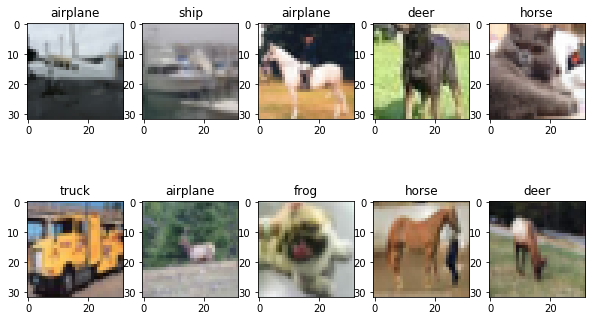

In [14]:
plt.figure(figsize=(10, 6))
for idx,i in enumerate(range(100,110)):
    plt.subplot(2, 5, idx+1)
    rand_ind = np.random.randint(0,X_test.shape[0])
    predicted_class = np.argmax(np.squeeze(model.predict(np.expand_dims(X_test[rand_ind,:,:,:],axis=0))))
    plt.imshow(X_test[rand_ind,:,:,:])
    plt.title(cifar_10_list[int(predicted_class)])

## Now, display all (32) trained filters of the first layer

You can explore the network parameters easily with Keras. For example ```model.layers``` is a list of the layers of the network. Each element of the network contains the information necessary for this layer. To show the content of a layer i, type :

```dir(model.layers[i])```

Display all (32) trained filters of the first layer :

32
(3, 3)
(3, 3, 3, 32)


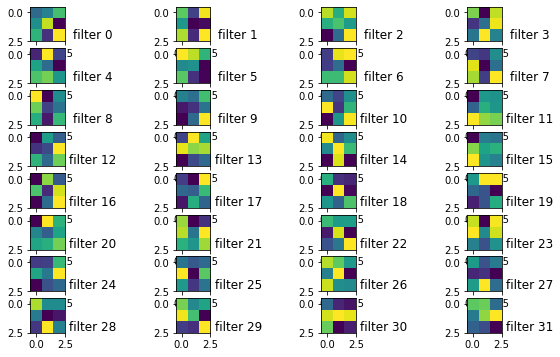

In [17]:
print(model.layers[0].filters)
print(model.layers[0].kernel_size)
print(model.layers[0].get_weights()[0].shape)
plt.figure(figsize=(10, 6))
for num in range(0,32):
    plt.subplot(8, 4, num+1)
    # --- START CODE HERE
    #plt.imshow((model.layers[0].get_weights()[0][:,:,:,num] * 255).astype(np.uint8))
    plt.imshow(model.layers[0].get_weights()[0][:,:,0,num])
    plt.title("filter {}".format(num), x=1.8, y=-0.1)
    # --- END CODE HERE    